### Challenge 7
Se utiliza la base de datos obtenida de PhysioNet "VinDr-SpineXR: A large annotated medical image dataset for spinal lesions detection and classification from radiographs". Esta contiene imágenes de rayos X en formato dicom de 13 enfermedades [1]. Se seleccionaron 50 imagenes de 3 tipos: Disc space narrowing, Foramidal steanosis y Vertebral Collpase.

[1] P. Hieu Huy. “VinDr-SpineXR: A large annotated medical image dataset for spinal lesions detection and classification from radiographs”. PhysioNet. Accedido el 24 de mayo de 2024. [En línea]. Disponible: https://physionet.org/content/vindr-spinexr/1.0.0/

In [53]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pydicom
import os
import cv2

In [54]:
def load_dicom_images(folder_path, target_size=(128, 128)):
    images = []
    print(f"Loading DICOM images from: {folder_path}")
    for subdir, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".dicom"):
                dicom_path = os.path.join(subdir, file)
                try:
                    ds = pydicom.dcmread(dicom_path)
                    image = ds.pixel_array
                    if len(image.shape) == 3:  # Verificar si la imagen tiene 3 canales (color)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
                    image_resized = cv2.resize(image, target_size)  # Redimensionar la imagen
                    images.append(image_resized)
                except Exception as e:
                    print(f"Error reading DICOM file {dicom_path}: {e}")
    print(f"Loaded {len(images)} images from {folder_path}")
    return np.array(images)


In [55]:
# Rutas de las carpetas con las imágenes DICOM
disc_space_narrowing_path = r'D:\DESK\PATRONUS\chllng_dicom\images_dicom\Disc_space_narrowing'
foramidal_stenosis_path = r'D:\DESK\PATRONUS\chllng_dicom\images_dicom\Foramidal_steanosis'
vertebral_collapse_path = r'D:\DESK\PATRONUS\chllng_dicom\images_dicom\Vertebral_collapse'

# Cargar imágenes y redimensionarlas
images_disc_space_narrowing = load_dicom_images(disc_space_narrowing_path)
images_foramidal_stenosis = load_dicom_images(foramidal_stenosis_path)
images_vertebral_collapse = load_dicom_images(vertebral_collapse_path)

Loading DICOM images from: D:\DESK\PATRONUS\chllng_dicom\images_dicom\Disc_space_narrowing


c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Loaded 50 images from D:\DESK\PATRONUS\chllng_dicom\images_dicom\Disc_space_narrowing
Loading DICOM images from: D:\DESK\PATRONUS\chllng_dicom\images_dicom\Foramidal_steanosis
Loaded 50 images from D:\DESK\PATRONUS\chllng_dicom\images_dicom\Foramidal_steanosis
Loading DICOM images from: D:\DESK\PATRONUS\chllng_dicom\images_dicom\Vertebral_collapse
Loaded 50 images from D:\DESK\PATRONUS\chllng_dicom\images_dicom\Vertebral_collapse


In [56]:
# Seleccionar 50 imágenes de cada enfermedad
images_disc_space_narrowing = images_disc_space_narrowing[:50]
images_foramidal_stenosis = images_foramidal_stenosis[:50]
images_vertebral_collapse = images_vertebral_collapse[:50]

# Crear las etiquetas
labels_disc_space_narrowing = np.full(50, 0)  # 0 para disc space narrowing
labels_foramidal_stenosis = np.full(50, 1)  # 1 para foramidal stenosis
labels_vertebral_collapse = np.full(50, 2)  # 2 para vertebral collapse

# Combinar todas las imágenes y etiquetas
images = np.concatenate((images_disc_space_narrowing, images_foramidal_stenosis, images_vertebral_collapse), axis=0)
labels = np.concatenate((labels_disc_space_narrowing, labels_foramidal_stenosis, labels_vertebral_collapse), axis=0)

# Añadir una dimensión para el canal
images = images[..., np.newaxis]

# Normalizar las imágenes
images = images / np.max(images)

In [57]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convertir etiquetas a formato one-hot
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)


In [79]:
# Crear y compilar la red neuronal de varias capas
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [80]:
# Entrenar el modelo
history=model.fit(X_train, y_train, epochs=30, batch_size=20, validation_split=0.2)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.3313 - loss: 1.0998 - val_accuracy: 0.2083 - val_loss: 1.1152
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.3868 - loss: 1.0776 - val_accuracy: 0.2083 - val_loss: 1.1035
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4042 - loss: 1.0769 - val_accuracy: 0.2500 - val_loss: 1.0992
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.3507 - loss: 1.0777 - val_accuracy: 0.2083 - val_loss: 1.0929
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.3868 - loss: 1.0789 - val_accuracy: 0.4167 - val_loss: 1.1136
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.5229 - loss: 1.0616 - val_accuracy: 0.2083 - val_loss: 1.0900
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.4972 - loss: 1.0198 - val_accuracy: 0.4583 - val_loss: 1.0567
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.5924 - loss: 1.0037 - val_accuracy: 0.4583 - val_loss:

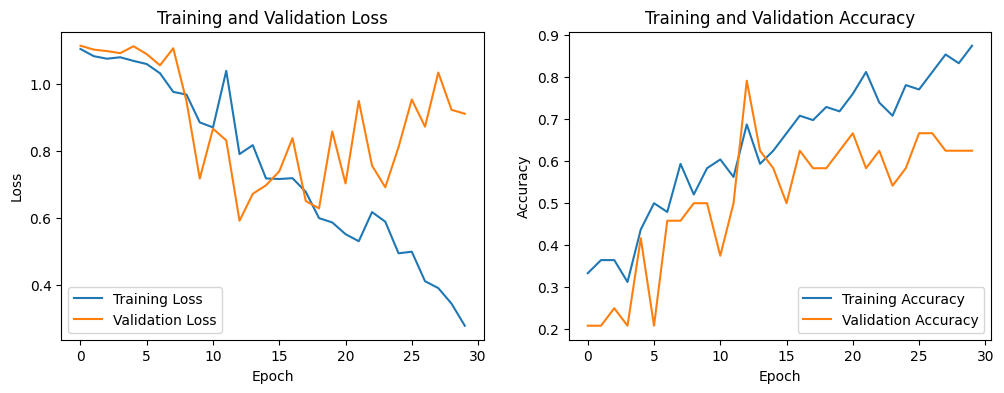

In [81]:
import matplotlib.pyplot as plt
# Graficar las pérdidas y precisiones
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()